# Euler 2

## Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%reset -f

In [3]:
%cd /content/drive/MyDrive/RECHERCHE3
%ls

/content/drive/.shortcut-targets-by-id/17bT9qzfPBT-758cXfyfE3KbFtOk0U2aT/RECHERCHE3
ddqn_lib/   GCN/          model_1.h5     popup_lib/
Euler/      GCN.zip       model_2.h5     transformer/
Euler2/     Hamilton/     model_vNet.h5  transformer_old/
Euler_old/  Hamilton.zip  Pinns/         translations/


In [4]:
import matplotlib.pyplot as plt
import popup_lib.popup as pop
import numpy as np
import time

import tensorflow as tf

np.set_printoptions(precision=3, linewidth=100000)

Popup loaded!


In [5]:
from Euler2.param import Projecter,Param
from Euler2.agent import Agent
from Euler2.core_sorver_commun import compute_solutions_accelerate,compute_solutions_nan_filtred, flux_with_diffu_order1, flux_with_diffu_order2
from Euler2.neural_network import Model
from Euler2.initial_conditions_burger import FuncGenerator

agent loaed


In [6]:
param = Param(1000, 10)
projecter=Projecter(param.nx_ratio)
order=2
odd_shrinkage= (order==1) #la taille du champs de vision, c'est le shrinkage +1

fam_size = 6
period_duration = "2 steps" 
all_agents = []

def one_family():
    agents = []
    for _ in range(fam_size):
        model_D = Model(input_dim=2,  odd_shrinkage=odd_shrinkage)
        agent = Agent(param, model_D, addi=False, order=order)
        agents.append(agent)
        all_agents.append(agent)

    return pop.Family_trainer(
        agents=agents,
        nb_bestweights_averaged=3,
        nb_strong=3,
        period_duration=period_duration,
        )

family_trainers = [one_family()]
nb_examples = 200
nb_t = 800
funcGen=FuncGenerator(param,nb_examples,False)


def load_data():
    w_init = funcGen()
    ws_train = compute_solutions_nan_filtred(param, nb_t, w_init, 1, None, False)
    ws_train_coarse=projecter.projection_4D(ws_train)
    w_init = funcGen()
    ws_val = compute_solutions_nan_filtred(param, nb_t, w_init, 1, None, False)
    ws_val_coarse =projecter.projection_4D(ws_val)

    nb_nan_allowed=3
    if nb_examples-ws_train.shape[0]>nb_nan_allowed or nb_examples-ws_val.shape[0]>nb_nan_allowed:
        print("ATTENTION TROP DE NAN, cela peut provoquer un grand nombre de retraçage de la fonction de projection")

    for agent in all_agents:
        agent.load_ws_train(ws_train,ws_train_coarse)
        agent.load_ws_val(ws_val,ws_val_coarse)


Param initialised with, nx=1000, nx_coarse=99
modèle crée avec un schrinkage de: 4
modèle crée avec un schrinkage de: 4
modèle crée avec un schrinkage de: 4
modèle crée avec un schrinkage de: 4
modèle crée avec un schrinkage de: 4
modèle crée avec un schrinkage de: 4


In [7]:
try:
    for i in range(2):
        load_data()
        for family_trainer in family_trainers:
            family_trainer.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        # pour pouvoir reprendre si on veut
        family_trainer.interupt_period()

traçage de la projection 4d pour la shape (800, 200, 1000, 1)

fam_1,échauffement Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
a↗6.6686Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
b↗7.2343Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
c↗7.9171Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
d↗9.5829Traçage de la méthode gradient_tape avec les tenseurs w_init:(256, 99, 1), w_final:(256, 99, 1)
Traçage de la méthode 

### Historique des `famparams`

In [8]:
def plot_history_famparams():
    keys=["lossCoef_stab","lossCoef_ridge","watch_duration","score"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
#plot_history_famparams()

### Historique des `loss`

In [9]:
def plot_history_losses():
    # keys=["loss_stab","loss_disHLL","loss_ridge","loss_Laplacian"]
    keys=["loss_stab","loss_ridge",
          "loss_stab*coef","loss_ridge*coef",
          "score_l1","score_l2","score_linfty"
          ]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
#plot_history_losses()

### Prédictions

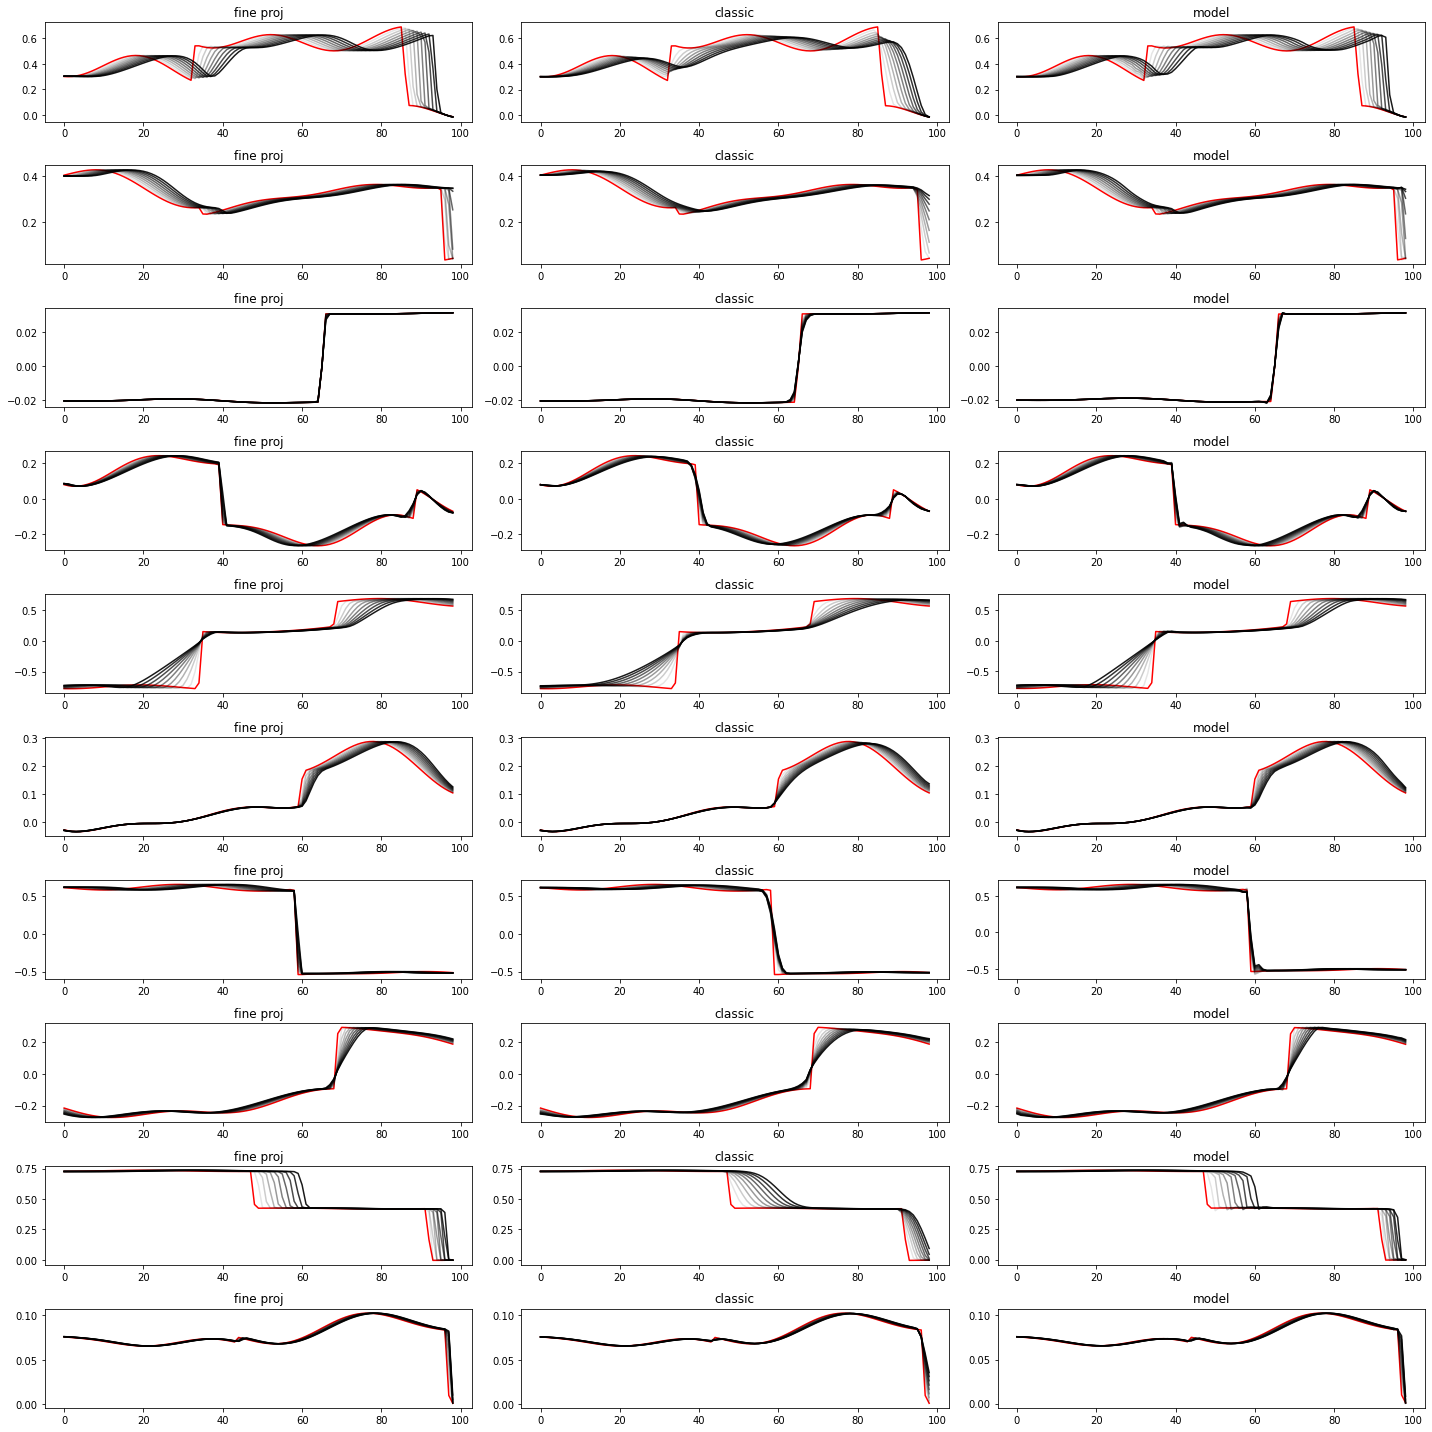

In [10]:
agent=family_trainers[0].get_best_agent()
fine_proj, res_classic, res_model = agent.predict()

nb_example_ploted=10
fig, ax = plt.subplots(nb_example_ploted,3,figsize=(20,nb_example_ploted*2))
for t in range(0, nb_t, nb_t // 10):
    color = "r" if t == 0 else "k"
    alpha = 1 if t == 0 else t / nb_t
    for j in range(nb_example_ploted
):
        ax[j,0].set_title("fine proj")
        ax[j,0].plot(fine_proj[t, j, :, 0], color, alpha=alpha)

        ax[j,1].set_title("classic")
        ax[j,1].plot(res_classic[t, j, :, 0], color, alpha=alpha)

        ax[j,2].set_title("model")
        ax[j,2].plot(res_model[t, j, :, 0], color, alpha=alpha)

fig.tight_layout()
plt.show()